In [102]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
## Load data
month_data_no_census = np.load('../data/covid/covid_month_no_census.npy', allow_pickle=True)
month_data_with_census = np.load('../data/covid/covid_month_with_census.npy',allow_pickle=True)
print(month_data_no_census.shape, month_data_with_census.shape)
month_data_df = pd.read_csv('../data/covid/covid_month.csv')
month_data_df.head()

(1110, 5) (1110, 172)


,Unnamed: 0,month,region,cases
0,0,3,Acton,0
1,1,3,Adams-Normandie,5
2,2,3,Agoura Hills,56
3,3,3,Alhambra,90
4,4,3,Alsace,0


# Naive train-test split

In [7]:
month_no_census_X = month_data_no_census[:, 1:]
month_no_census_X = month_no_census_X[:,:-1]
month_no_census_y = month_data_no_census[:, -1]

month_with_census_X = month_data_with_census[:, 1:]
month_with_census_X = month_with_census_X[:,:-1]
month_with_census_y = month_data_with_census[:, -1]

print(month_no_census_X.shape, month_with_census_X.shape)

(1110, 3) (1110, 170)


In [8]:
month_no_census_X_train, month_no_census_X_test, month_no_census_y_train, month_no_census_y_test = train_test_split(
    month_no_census_X, month_no_census_y, test_size=0.4, random_state=42)
month_with_census_X_train, month_with_census_X_test, month_with_census_y_train, month_with_census_y_test = train_test_split(
    month_with_census_X, month_with_census_y, test_size=0.4, random_state=42)

# Time Validation

In [53]:
def one_time_split(data):
    # Index of first row with month == 4
    first_index = np.where(data[:,0]==4)[0][0]
    print(first_index)
    # Index of first row with month == 8
    last_index = np.where(data[:,0] == 8)[0][0]
    
    # Split into train test
    X_train = data[first_index:last_index, 1:-1]
    X_test = data[last_index:, 1:-1]
    y_train = data[first_index:last_index, -1]
    y_test = data[last_index:, -1]
    
    return(X_train,X_test,y_train,y_test)

In [123]:
def multiple_time_split(data):
    X_train_arr = []
    X_test_arr = []
    y_train_arr = []
    y_test_arr = []
    for i in range(4,7):
        train_start_index = np.where(data[:,0]==i)[0][0]
        test_start_index = np.where(data[:,0]==i+2)[0][0]
        test_end_index = np.where(data[:,0]==i+3)[0][0] if i!=6 else data.shape[0]
        X_train = data[train_start_index:test_start_index, 1:-1]
        X_test = data[test_start_index:test_end_index, 1:-1]
        y_train = data[train_start_index:test_start_index, -1]
        y_test = data[test_start_index:test_end_index, -1]
        
        print('============')
        print(train_start_index, test_start_index, test_end_index)
        print('============')
        
        X_train_arr.append(X_train)
        X_test_arr.append(X_test)
        y_train_arr.append(y_train)
        y_test_arr.append(y_test)
        
    return (X_train_arr, X_test_arr, y_train_arr, y_test_arr)

In [125]:
month_no_census_X_train, month_no_census_X_test, month_no_census_y_train, month_no_census_y_test = one_time_split(
    month_data_no_census)
print(month_no_census_X_test.shape)

185
(185, 3)


In [126]:
month_with_census_X_train, month_with_census_X_test, month_with_census_y_train, month_with_census_y_test = one_time_split(
    month_data_with_census)
print(month_with_census_X_test.shape)

185
(185, 170)


In [127]:
month_no_census_X_train_arr, month_no_census_X_test_arr, month_no_census_y_train_arr, month_no_census_y_test_arr = multiple_time_split(
    month_data_no_census)
print(month_no_census_X_train_arr[1].shape)

185 555 740
370 740 925
555 925 1110
(370, 3)


In [130]:
print(month_no_census_y_test_arr[1].shape)

(185,)


In [129]:
month_with_census_X_train_arr, month_with_census_X_test_arr, month_with_census_y_train_arr, month_with_census_y_test_arr = multiple_time_split(
    month_data_with_census)
print(month_with_census_X_train_arr[2].shape)

185 555 740
370 740 925
555 925 1110
(370, 170)


# Linear Reg

In [14]:
lin_model_no_census = LinearRegression()
lin_model_no_census.fit(month_no_census_X_train, month_no_census_y_train)
lin_model_with_census = LinearRegression()
lin_model_with_census.fit(month_with_census_X_train, month_with_census_y_train)

LinearRegression()

In [15]:
month_no_census_y_lin_pred = lin_model_no_census.predict(month_no_census_X_test)
month_no_census_lin_mse = mean_squared_error(month_no_census_y_lin_pred, month_no_census_y_test)
month_with_census_y_lin_pred = lin_model_with_census.predict(month_with_census_X_test)
month_with_census_lin_mse = mean_squared_error(month_with_census_y_lin_pred, month_with_census_y_test)
print(month_no_census_lin_mse, month_with_census_lin_mse)

38765819.61072869 2018361764.7313585


# SVR

In [18]:
svr_model = SVR()
svr_model.fit(month_X_train, month_y_train)

SVR()

In [19]:
month_y_pred = svr_model.predict(month_X_test)

In [20]:
mse = mean_squared_error(month_y_pred, month_y_test)
mse

747207503.8776608

In [51]:
month_no_census_X_test.shape

(444, 3)

# Gradient Boosting

In [151]:
params = {'n_estimators': 1000,
          'max_depth': 32,
          'min_samples_split': 100,
          'learning_rate': 0.01,
          'loss': 'ls'}

## One split

### No census

In [156]:
gb_nc1s1m = GradientBoostingRegressor(**params)
gb_nc1s1m.fit(month_no_census_X_train, month_no_census_y_train)
gb_nc1s1m_y_pred = gb_nc1s1m.predict(month_no_census_X_test)
gb_nc1s1m_mse = mean_squared_error(gb_nc1s1m_y_pred, month_no_census_y_test)
gb_nc1s1m_r2 = r2_score(gb_nc1s1m_y_pred, month_no_census_y_test)
gb_nc1s1m_mae = mean_absolute_error(gb_nc1s1m_y_pred, month_no_census_y_test)
print('MSE: {a} \nr2: {b} \nMAE: {c} \navg: {d}'.format(a=gb_nc1s1m_mse, b=gb_nc1s1m_r2, c=gb_nc1s1m_mae, d=np.average(month_no_census_y_test)))

MSE: 246672046.2464402 
r2: 0.8721149759689055 
MAE: 11585.410526075506 
avg: 34373.33513513514


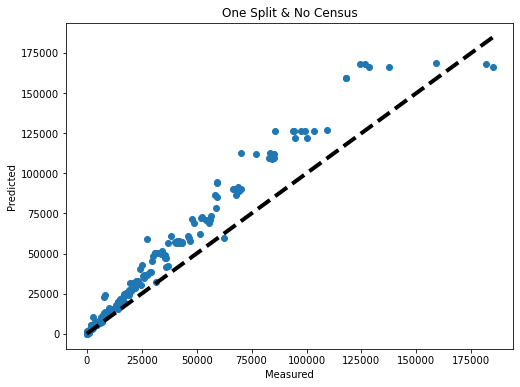

In [163]:
fig, ax = plt.subplots(figsize=[8,6])
ax.scatter(month_no_census_y_test, gb_nc1s1m_y_pred)
ax.plot([month_no_census_y_test.min(), month_no_census_y_test.max()], [month_no_census_y_test.min(), month_no_census_y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('One Split & No Census')
plt.show()

### With census

In [158]:
gb_wc1s1m = GradientBoostingRegressor(**params)
gb_wc1s1m.fit(month_with_census_X_train, month_with_census_y_train)
gb_wc1s1m_y_pred = gb_wc1s1m.predict(month_with_census_X_test)
gb_wc1s1m_mse = mean_squared_error(gb_wc1s1m_y_pred, month_with_census_y_test)
gb_wc1s1m_r2 = r2_score(gb_wc1s1m_y_pred, month_with_census_y_test)
gb_wc1s1m_mae = mean_absolute_error(gb_wc1s1m_y_pred, month_with_census_y_test)
print('MSE: {a} \nr2: {b} \nMAE: {c} \navg: {d}'.format(a=gb_wc1s1m_mse, b=gb_wc1s1m_r2, c=gb_wc1s1m_mae, d=np.average(month_with_census_y_test)))

MSE: 193689871.68335584 
r2: 0.892283420998371 
MAE: 10499.062552668602 
avg: 34373.33513513514


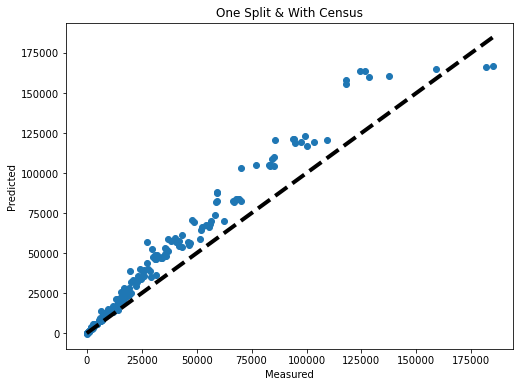

In [164]:
fig, ax = plt.subplots(figsize=[8,6])
ax.scatter(month_with_census_y_test, gb_wc1s1m_y_pred)
ax.plot([month_with_census_y_test.min(), month_with_census_y_test.max()], [month_with_census_y_test.min(), month_with_census_y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('One Split & With Census')
plt.show()

## Multiple Splits

### No census

In [154]:
gb_ncms1m_y_pred_arr = []
gb_ncms1m_mse_arr = []
gb_ncms1m_r2_arr = []
gb_ncms1m_mae_arr = []
gb_ncms1m_avg_arr = []

for i in range(len(month_no_census_X_train_arr)):
    gb_ncms1m = GradientBoostingRegressor(**params)
    gb_ncms1m.fit(month_no_census_X_train_arr[i], month_no_census_y_train_arr[i])
    gb_ncms1m_y_pred_arr.append(gb_ncms1m.predict(month_no_census_X_test_arr[i]))
    gb_ncms1m_mse_arr.append(mean_squared_error(gb_ncms1m_y_pred_arr[i], month_no_census_y_test_arr[i]))
    gb_ncms1m_r2_arr.append(r2_score(gb_ncms1m_y_pred_arr[i], month_no_census_y_test_arr[i]))
    gb_ncms1m_mae_arr.append(mean_absolute_error(gb_ncms1m_y_pred_arr[i], month_no_census_y_test_arr[i]))
    gb_ncms1m_avg_arr.append(np.average(month_no_census_y_test_arr[i]))
print('MSE: {a} \nr2: {b} \nMAE: {c} \navg: {d}'.format(a=gb_ncms1m_mse_arr, b=gb_ncms1m_r2_arr, c=gb_ncms1m_mae_arr, d=gb_ncms1m_avg_arr))

MSE: [172767729.55693838, 173403490.4071879, 237016101.51701272] 
r2: [0.12211109418054145, 0.8411414167152818, 0.8770114355231811] 
MAE: [6820.282265593809, 8500.12176585393, 11188.6344162995] 
avg: [19915.90810810811, 30415.097297297296, 34373.33513513514]


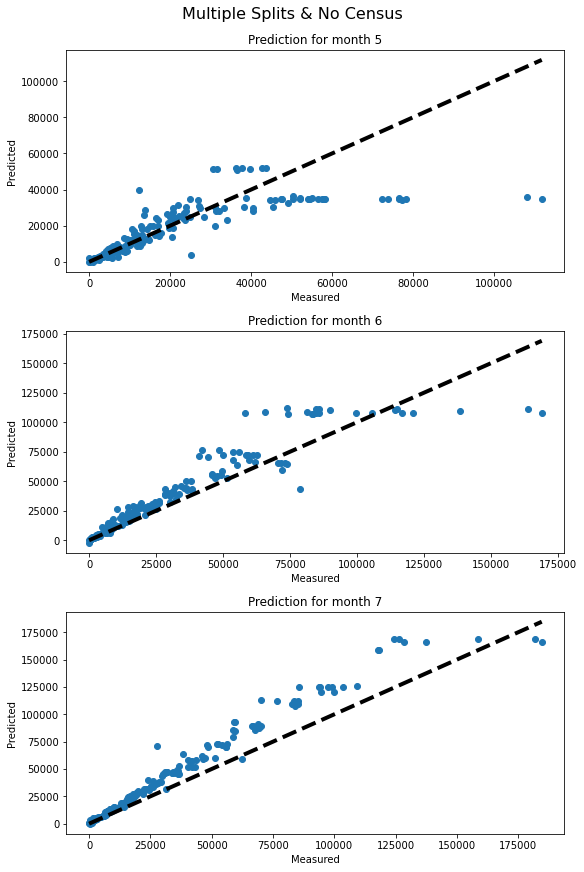

In [174]:
fig, axs = plt.subplots(len(gb_ncms1m_avg_arr), figsize=[8,12], constrained_layout=True)
for i in range(len(gb_ncms1m_avg_arr)):
    axs[i].scatter(month_no_census_y_test_arr[i], gb_ncms1m_y_pred_arr[i])
    axs[i].plot([month_no_census_y_test_arr[i].min(), month_no_census_y_test_arr[i].max()], [month_no_census_y_test_arr[i].min(), month_no_census_y_test_arr[i].max()], 'k--', lw=4)
    axs[i].set_xlabel('Measured')
    axs[i].set_ylabel('Predicted')
    axs[i].set_title('Prediction for month {m}'.format(m=i+5))
fig.suptitle('Multiple Splits & No Census', fontsize=16)
plt.show()

### With census

In [152]:
gb_wcms1m_y_pred_arr = []
gb_wcms1m_mse_arr = []
gb_wcms1m_r2_arr = []
gb_wcms1m_mae_arr = []
gb_wcms1m_avg_arr = []

for i in range(len(month_with_census_X_train_arr)):
    gb_wcms1m = GradientBoostingRegressor(**params)
    gb_wcms1m.fit(month_with_census_X_train_arr[i], month_with_census_y_train_arr[i])
    gb_wcms1m_y_pred_arr.append(gb_wcms1m.predict(month_with_census_X_test_arr[i]))
    gb_wcms1m_mse_arr.append(mean_squared_error(gb_wcms1m_y_pred_arr[i], month_with_census_y_test_arr[i]))
    gb_wcms1m_r2_arr.append(r2_score(gb_wcms1m_y_pred_arr[i], month_with_census_y_test_arr[i]))
    gb_wcms1m_mae_arr.append(mean_absolute_error(gb_wcms1m_y_pred_arr[i], month_with_census_y_test_arr[i]))
    gb_wcms1m_avg_arr.append(np.average(month_with_census_y_test_arr[i]))
print('MSE: {a} \nr2: {b} \nMAE: {c} \navg: {d}'.format(a=gb_wcms1m_mse_arr, b=gb_wcms1m_r2_arr, c=gb_wcms1m_mae_arr, d=gb_wcms1m_avg_arr))

MSE: [135628472.41688806, 127051085.32228665, 203003832.52963245] 
r2: [0.2574687859975696, 0.87558710480614, 0.8910183795770634] 
MAE: [5597.336673489539, 6944.043714940586, 10551.663902427525] 
avg: [19915.90810810811, 30415.097297297296, 34373.33513513514]


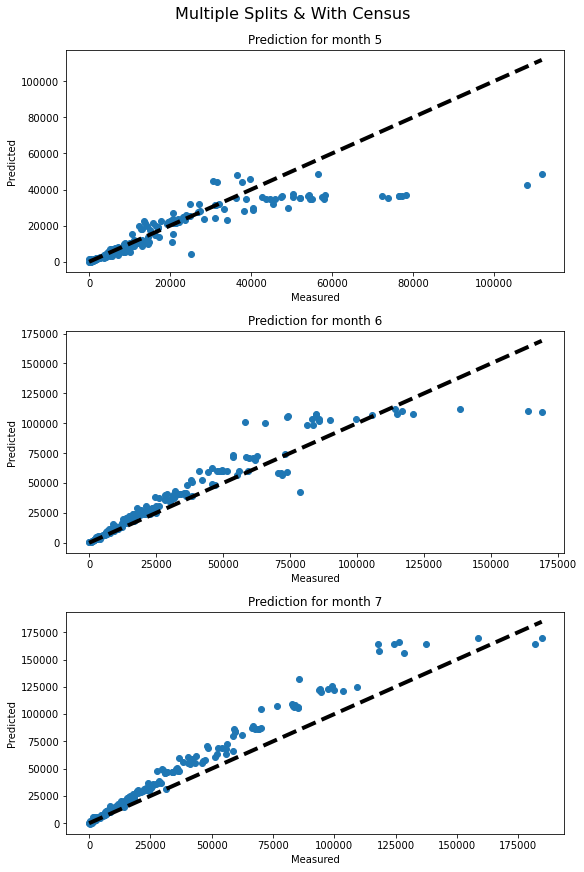

In [175]:
fig, axs = plt.subplots(len(gb_wcms1m_avg_arr), figsize=[8,12], constrained_layout=True)
for i in range(len(gb_wcms1m_avg_arr)):
    axs[i].scatter(month_with_census_y_test_arr[i], gb_wcms1m_y_pred_arr[i])
    axs[i].plot([month_with_census_y_test_arr[i].min(), month_with_census_y_test_arr[i].max()], [month_with_census_y_test_arr[i].min(), month_with_census_y_test_arr[i].max()], 'k--', lw=4)
    axs[i].set_xlabel('Measured')
    axs[i].set_ylabel('Predicted')
    axs[i].set_title('Prediction for month {m}'.format(m=i+5))
fig.suptitle('Multiple Splits & With Census', fontsize=16)
plt.show()